# 5.2. Picking a Kaggle data set to work on

## Loading the data: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [2]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
import pathlib
data_dir = pathlib.Path('chest_xray')

In [4]:
image_count = len(list(data_dir.glob('*/*/*.jpeg')))
image_count

5856

In [5]:
CLASS_NAMES = np.array(list(set([item.name for item in data_dir.glob('*/*') if item.name.upper() == item.name])))
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [6]:
import os

# more info: https://www.tensorflow.org/tutorials/load_data/images

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES
def decode_img(img):
    # convert the compressed string to a 1D tensor
    img = tf.image.decode_jpeg(img, channels=1)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

def get_dataset(path):
    list_ds = tf.data.Dataset.list_files(os.path.join(str(data_dir), path, '*/*'))
    labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    ds = prepare_for_training(labeled_ds)

    return ds

In [7]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(np.squeeze(image_batch[n]))
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

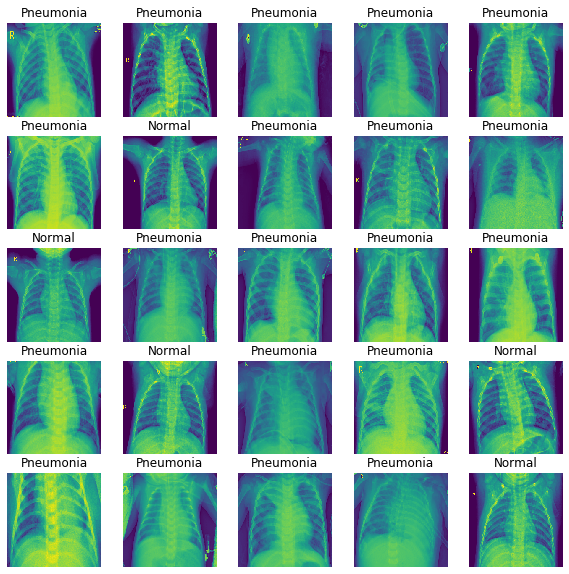

In [8]:
train_ds = get_dataset('train')
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Base model

In [29]:
# https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                                               include_top=False,
                                               weights='imagenet')

In [30]:
image_3chan_batch = np.repeat(image_batch, 3, -1)
image_3chan_batch.shape

(32, 224, 224, 3)

In [31]:
feature_batch = base_model(image_3chan_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)
